<a href="https://colab.research.google.com/github/pratyaksh12/Colon-Cancer-Cell-Classification/blob/main/MachineLearningAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Machine-Learning-Assignment-2/

/content/drive/MyDrive/Machine-Learning-Assignment-2


In [ ]:
from pathlib import Path

main_path = Path('Image_classification_data')
main_path.mkdir(parents= True, exist_ok= True)

In [ ]:
# unzipping the data file
import zipfile

with zipfile.ZipFile('Image_classification_data.zip', 'r') as zipref:
  zipref.extractall(main_path)

# Section 1 (EDA and Class Imbalance)

In [ ]:
# importing modules

import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [ ]:
!nvidia-smi

Sun May 18 09:44:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
all_images_path = Path('Image_classification_data/patch_images')
data_path = Path('Image_classification_data/data_labels_mainData.csv')
print(all_images_path.exists())
print(data_path.exists())

True
True


In [ ]:
#load the images data to a pandas dataframe
data_df = pd.read_csv(data_path)
#check the data
print(data_df)

      InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0          22405          1  22405.png   fibroblast         0            0
1          22406          1  22406.png   fibroblast         0            0
2          22407          1  22407.png   fibroblast         0            0
3          22408          1  22408.png   fibroblast         0            0
4          22409          1  22409.png   fibroblast         0            0
...          ...        ...        ...          ...       ...          ...
9891        1625         60   1625.png   epithelial         2            1
9892        1626         60   1626.png   epithelial         2            1
9893        1627         60   1627.png   epithelial         2            1
9894        1628         60   1628.png   epithelial         2            1
9895        1629         60   1629.png   epithelial         2            1

[9896 rows x 6 columns]


### Checking for class imbalances

<BarContainer object of 4 artists>

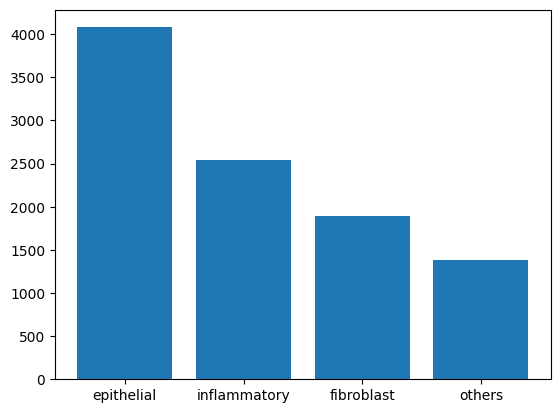

In [ ]:
class_count = data_df['cellTypeName'].value_counts()
plt.bar(class_count.index, class_count.values)

In [ ]:
#Percentage contribution of each cell type in the dataset

for cell_type, count in class_count.items():
    print(f"Cell Type: {cell_type}, Count: {count}")
    print(f"Percentage: {count / len(data_df) * 100:.2f}%")
    print('\n\n')

Cell Type: epithelial, Count: 4079
Percentage: 41.22%



Cell Type: inflammatory, Count: 2543
Percentage: 25.70%



Cell Type: fibroblast, Count: 1888
Percentage: 19.08%



Cell Type: others, Count: 1386
Percentage: 14.01%





##Observation from the Data Distribution:

The data distribution shows that epithelial cells make up the largest portion at 41.22%, while the “Other” cell type represents the smallest portion at 14.01%. This indicates that the dataset is unevenly distributed, with a strong bias toward epithelial cells. To improve the fairness and accuracy of any analysis or model built on this data, it is necessary to balance the dataset so that all cell types are more equally represented.

In [ ]:
# creating a new column for complete image paths to directly access from the dataframe

data_df['image_path'] = data_df['ImageName'].apply(lambda x : all_images_path / x)
data_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,image_path
0,22405,1,22405.png,fibroblast,0,0,Image_classification_data/patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,Image_classification_data/patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,Image_classification_data/patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,Image_classification_data/patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,Image_classification_data/patch_images/22409.png


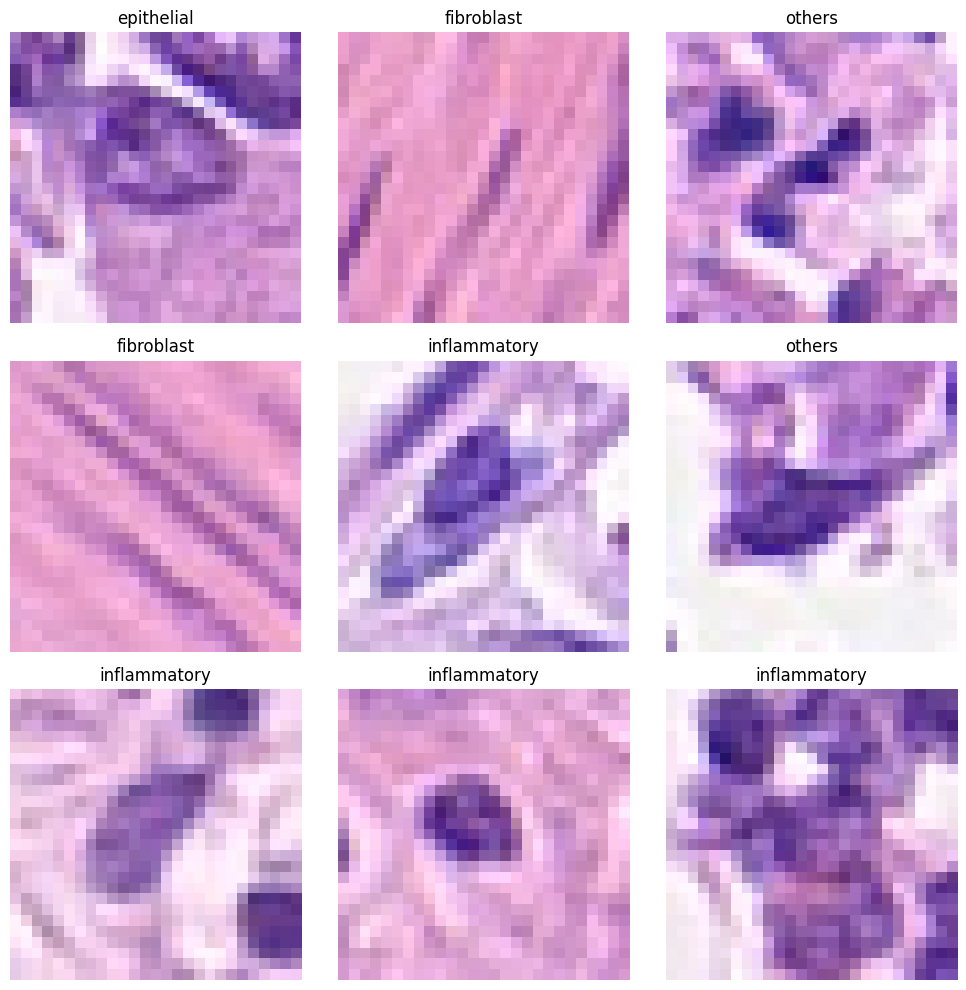

In [ ]:
# visual check of images

torch.manual_seed(1)
plt.figure(figsize=(10, 10))
for i in range(9):
    random_idx = torch.randint(0, len(data_df), size=(1,)).item()
    image_df = data_df.iloc[random_idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(image_df['image_path']))
    plt.title(image_df['cellTypeName'])
    plt.axis('off')
plt.tight_layout()

In [ ]:
# understanding the structure of each image

img = Image.open(data_df['image_path'].iloc[0])
print("image width:", img.width)
print("image height:", img.height)
print("image color mode:", img.mode)

# images size are of 27 x 27 pixels and there are 3 color channels (RGB)

image width: 27
image height: 27
image color mode: RGB


## From the code above the following can be noted:
- Image width is `27px`
- Image height is `27px`
- Image has `3` color channels (Red, blue, green)

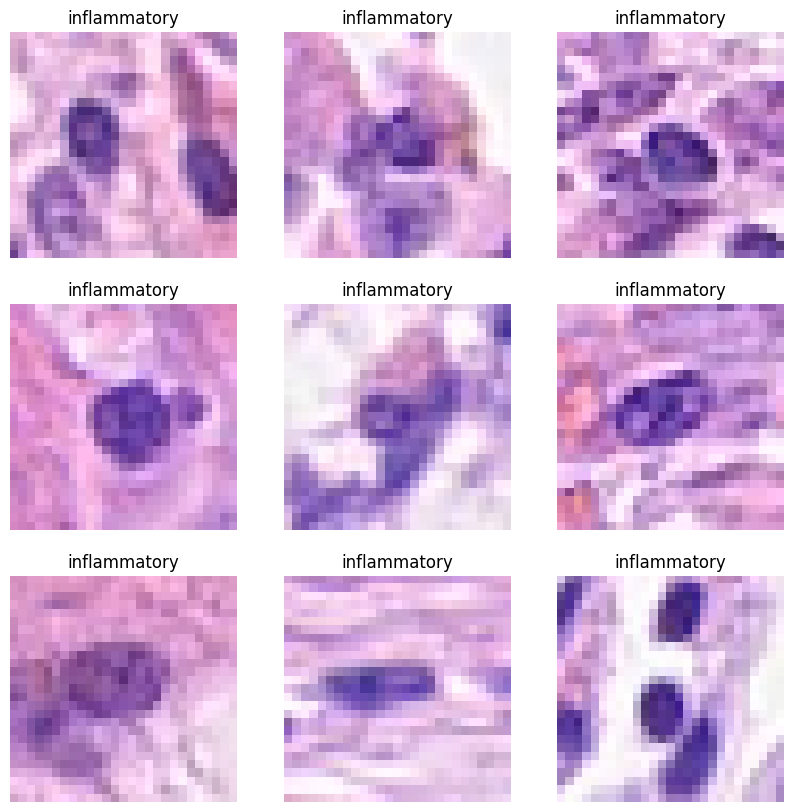

In [ ]:
# visual check of inflammatory cells
inflammatory_cells = data_df[data_df['cellTypeName'] == 'inflammatory']
plt.figure(figsize=(10, 10))
for i in range(9):
    random_idx = torch.randint(0, len(inflammatory_cells), size=(1,)).item()
    image_df = inflammatory_cells.iloc[random_idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(image_df['image_path']))
    plt.title(image_df['cellTypeName'])
    plt.axis('off')

## From the visual representation of `inflammatory cells` I can observe that:
- The shape of cell is more or less `circular`
- Generally in `patches` (more than one circular shapes)

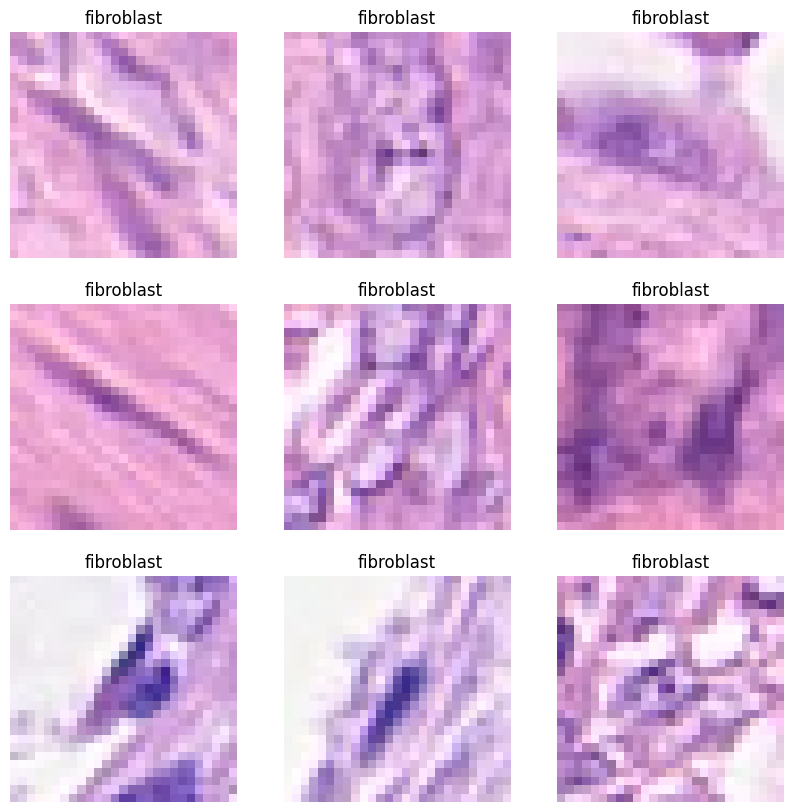

In [ ]:
# visual check of inflammatory cells
fibroblast = data_df[data_df['cellTypeName'] == 'fibroblast']
plt.figure(figsize=(10, 10))
for i in range(9):
    random_idx = torch.randint(0, len(fibroblast), size=(1,)).item()
    image_df = fibroblast.iloc[random_idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(image_df['image_path']))
    plt.title(image_df['cellTypeName'])
    plt.axis('off')

##From the visual representation of `fibroblast cells` I can observe that:
- The shape of cell is more or less `fiber-like`
- Generally in `layer like structure`

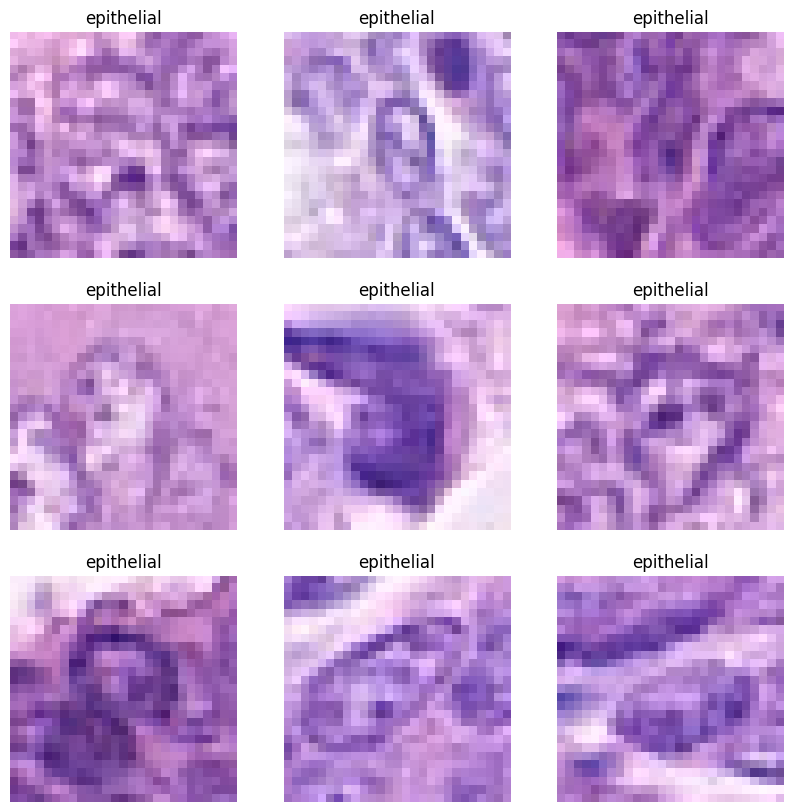

In [ ]:
# visual check of inflammatory cells
epithelial = data_df[data_df['cellTypeName'] == 'epithelial']
plt.figure(figsize=(10, 10))
for i in range(9):
    random_idx = torch.randint(0, len(epithelial), size=(1,)).item()
    image_df = epithelial.iloc[random_idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(image_df['image_path']))
    plt.title(image_df['cellTypeName'])
    plt.axis('off')

## From the visual representation of `epithelial cells` I can observe that:
- The shape of cell is more or less `circular`
- Generally in `single hollow` shape unlike the patchy appearence of imflammatory cells

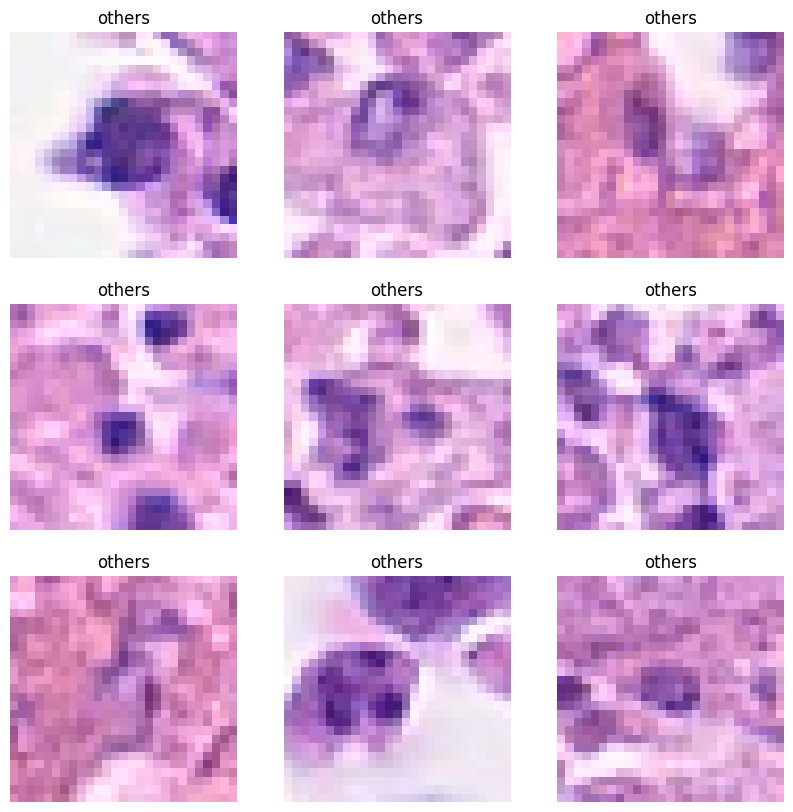

In [ ]:
# visual check of inflammatory cells
others = data_df[data_df['cellTypeName'] == 'others']
plt.figure(figsize=(10, 10))
for i in range(9):
    random_idx = torch.randint(0, len(others), size=(1,)).item()
    image_df = others.iloc[random_idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(Image.open(image_df['image_path']))
    plt.title(image_df['cellTypeName'])
    plt.axis('off')

## From the visual representation of `other cell types` I can observe that:
- The shape of cell is similar to epithelial and imflammatory which is confusing for human eyes
- The model might get confused and may generate response that might give the wrong classification for the data

In [ ]:
# tranformations and augmentations to be used for the training dataset

training_transformation = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
])


testing_transformation = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor()
])

## Data Augmentation for training and testing data

`The images has been upsized to 32 x 32 pixels as 27 x 27 provides less dimensionality that could cause underperformance in the model`

###Training data Augmentation
- A bunch of common practices are applied like:
  - Horizontal Flipping
  - Vertical Flipping
  - Rotation
  - Color Jittering

  this is done to make sure that the model is more robust and adaptable to real world noise that is really common. This is to make sure that the model doesn't train on only perfect examples but also imperfect ones for better adaptability.

  Augmentations like flips, rotations, and color jitter force the model to focus on shape, boundary, and structure too.


###Testing data augmentation
- Simple and straight forward approach
  - Resizing the image
  - Converting the images to Tensors for pyTorch functionality



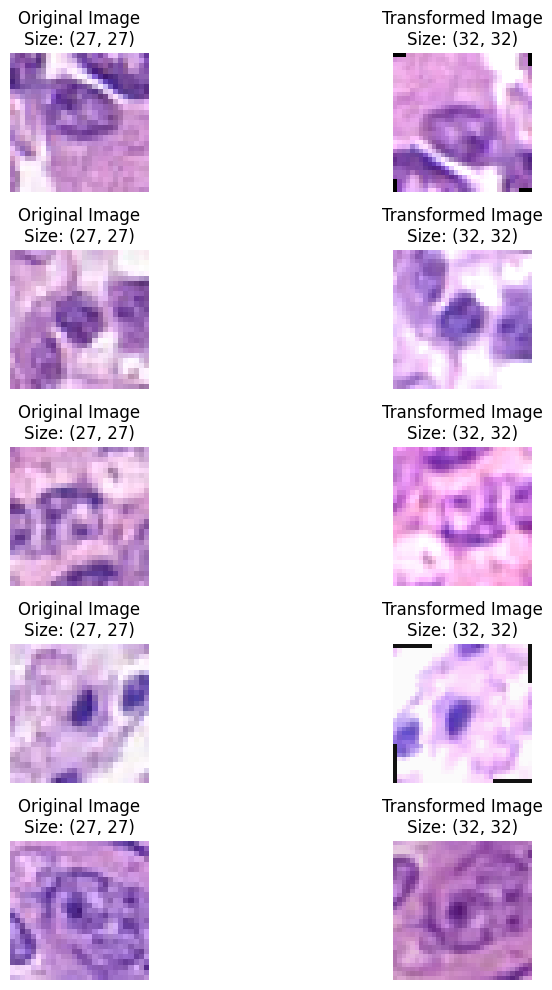

In [ ]:
# testing the transformation on the images

torch.manual_seed(1)

plt.figure(figsize=(10, 10))

for i in range(5):
    random_idx = torch.randint(0, len(data_df), size=(1,)).item()
    image_df = data_df.iloc[random_idx]

    # Load original image
    original_image = Image.open(image_df['image_path']).convert('RGB')  # Ensure RGB

    # Apply transformations
    transformed_tensor = training_transformation(original_image)

    # Convert tensor back to displayable format (0–1 range for imshow)
    transformed_image = transformed_tensor.permute(1, 2, 0).numpy()

    # Plot original image
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title("Original Image\n" + "Size: " + str(original_image.size))
    plt.xlabel("Cell Type: " + image_df['cellTypeName'])
    plt.axis('off')

    # Plot transformed image
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(transformed_image)
    plt.title("Transformed Image\n" + "Size: " + str(transformed_image.shape[:2]))
    plt.xlabel("Cell Type: " + image_df['cellTypeName'])
    plt.axis('off')

plt.tight_layout()
plt.show()


This visual representation of the actual images and transformed images shall give a better understanding as to what the augmentation refer to. The images are now a bit more hazy and unclear that would let the model focus more in shapes and spaces between patches

## Prevention of Data Leakage

#### Splitting the cell images based on `patient's ID` rather than randomly:
- The idea is that if the cells are split randomly without much consideration can lead the model to `leak` the histology, cell staining and patient specific cell texture into testing as well as validation set. Thus to mimic the real world situation, Training, validation and testing set have cells from different patients.

In [ ]:
data_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,image_path
0,22405,1,22405.png,fibroblast,0,0,Image_classification_data/patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,Image_classification_data/patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,Image_classification_data/patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,Image_classification_data/patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,Image_classification_data/patch_images/22409.png


In [ ]:
patients = data_df['patientID'].unique()

In [ ]:
patients

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

In [ ]:
from sklearn.model_selection import train_test_split

train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)
validation_patients, test_patients = train_test_split(test_patients, test_size=0.5, random_state=42)
print(f"Number of training patients: {len(train_patients)}")
print(f"Number of validation patients: {len(validation_patients)}")
print(f"Number of test patients: {len(test_patients)}")

Number of training patients: 48
Number of validation patients: 6
Number of test patients: 6


In [ ]:
train_df = data_df[data_df['patientID'].isin(train_patients)]
validation_df = data_df[data_df['patientID'].isin(validation_patients)]
test_df = data_df[data_df['patientID'].isin(test_patients)]

In [ ]:
print(train_df['patientID'].unique())
print(validation_df['patientID'].unique())
print(test_df['patientID'].unique())

[ 2  3  4  5  7  8  9 10 11 12 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 35 36 38 39 40 41 42 43 44 45 48 50 52 53 54 56 57 59 60]
[ 6 14 34 46 49 51]
[ 1 13 37 47 55 58]


In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))


8057
1012
827



###Training Set (80%)

- The model needs to learn to recognizesubtle patterns in complex cell images.

- A large training set allows the model to generalize better and reduce overfitting.


###Validation Set (10%)

- Used during training to tune hyperparameters and monitor overfitting.

- Provides a checkpoint to assess how well the model is generalizing to unseen data before final evaluation.

###Test Set (10%)

- Used in the last check

- Used to report the final accuracy, precision, recall, and F1-score, reflecting real-world performance.

In [ ]:
train_df['cellTypeName'].value_counts()

,count
cellTypeName,
epithelial,3154
inflammatory,2111
fibroblast,1627
others,1165


# Handling Class Imbalance

##Why Is This a Problem?
- The model gets trained on mostly majority class data.

- As a result, it struggles to correctly classify other important cells.

- This leads to high overall accuracy, but low recall and precision for minority classes causing misleading and dangerous in medical predictions.

##To address this, oversampling is applied:

Minority class samples are duplicated (or synthetically generated) in the training set.

This balances the class distribution, giving the model equal exposure to all cell types.




In [ ]:
inflammatory_cells_required = 2547 - 1832
fibroblast_required = 2547 - 1299
others_required = 2547 - 1100

print(f"Inflammatory cells required: {inflammatory_cells_required}")
print(f"Fibroblast required: {fibroblast_required}")
print(f"others required: {others_required}")

Inflammatory cells required: 715
Fibroblast required: 1248
others required: 1447


In [ ]:
oversampling_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(p= 0.8),
    transforms.RandomRotation(degrees=37, expand= False),
])

In [ ]:
import random

In [ ]:
augmented_images_path = Path('image_classification_data/augmented_images_minority')
augmented_images_path.mkdir(exist_ok= True, parents= True)

In [ ]:
augmented_df = pd.DataFrame(columns= test_df.columns)

In [ ]:
augmented_df

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,image_path


In [ ]:
# oversampling inflammatory cells

inflammatory_path = augmented_images_path / "inflammatory"
inflammatory_path.mkdir(exist_ok= True, parents= True)

print(inflammatory_path.exists())

while inflammatory_cells_required > 0:
    random_row = train_df[train_df['cellTypeName'] == 'inflammatory'].sample(n=1).iloc[0]

    augmented_img = oversampling_transformation(Image.open(random_row['image_path']))

    save_path = inflammatory_path / f"inflammatory_{inflammatory_cells_required}.png"
    augmented_img.save(save_path)

    new_row = random_row.copy()
    new_row['image_path'] = str(save_path)

    augmented_df = pd.concat([augmented_df, pd.DataFrame([new_row])], ignore_index=True)

    inflammatory_cells_required -= 1






True


In [ ]:
# oversampling fibroblast cells

fibroblast_path = augmented_images_path / "fibroblast"
fibroblast_path.mkdir(exist_ok= True, parents= True)

print(fibroblast_path.exists())

while fibroblast_required > 0:
    random_row = train_df[train_df['cellTypeName'] == 'fibroblast'].sample(n=1).iloc[0]

    augmented_img = oversampling_transformation(Image.open(random_row['image_path']))

    save_path = fibroblast_path / f"fibroblast_{fibroblast_required}.png"
    augmented_img.save(save_path)

    new_row = random_row.copy()
    new_row['image_path'] = str(save_path)

    augmented_df = pd.concat([augmented_df, pd.DataFrame([new_row])], ignore_index= True)

    fibroblast_required -= 1



True


In [ ]:
# oversampling others cell type

others_path = augmented_images_path / "others"
others_path.mkdir(exist_ok= True, parents= True)

print(others_path.exists())

while others_required > 0:
    random_row = train_df[train_df['cellTypeName'] == 'others'].sample(n= 1).iloc[0]

    augmented_img = oversampling_transformation(Image.open(random_row['image_path']))

    save_path = others_path / f"others_path_{others_required}.png"
    augmented_img.save(save_path)

    new_row = random_row.copy()
    new_row['image_path'] = str(save_path)

    augmented_df = pd.concat([augmented_df, pd.DataFrame([new_row])])

    others_required -= 1

True


##Identify Minority Classes
- The dataset is analyzed to determine which classes have fewer samples.
- The class with the highest count is used as a reference.

##For each minority class:
- Compute the difference between the majority class count and the current count:

##Use data augmentation to create new variants of existing minority class images.

- This generatesdiverse training samples.

In [ ]:
augmented_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,image_path
0,17141,29,17141.png,inflammatory,1,0,image_classification_data/augmented_images_min...
1,21194,57,21194.png,inflammatory,1,0,image_classification_data/augmented_images_min...
2,9963,41,9963.png,inflammatory,1,0,image_classification_data/augmented_images_min...
3,19052,2,19052.png,inflammatory,1,0,image_classification_data/augmented_images_min...
4,18703,4,18703.png,inflammatory,1,0,image_classification_data/augmented_images_min...


In [ ]:
train_df = pd.concat([train_df, augmented_df])
train_df['cellTypeName'].value_counts()

,count
cellTypeName,
epithelial,3154
fibroblast,2875
inflammatory,2826
others,2612


##Creating a Custom Image Folder
- Organize images into subfolders based on their class labels

- Simplifies data access and management

- Enables easier loading using image processing libraries

- Helps maintain a clear and scalable dataset structure

In [ ]:
def find_classes():
    classes = ['fibroblast', 'inflammatory', 'epithelial', 'others']
    class_to_idx = {
       'fibroblast' : 0,
       'inflammatory' : 1,
       'epithelial' : 2,
       'others' : 3
    }

    return classes, class_to_idx

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, dataframe, transform = None):
        self.data = dataframe
        self.paths = list(dataframe['image_path'])
        self.classes, self.class_to_idx = find_classes()
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize(size = (32, 32)),
            transforms.ToTensor(),
        ])

    def load_images(self, index):
        image_path = self.paths[index]
        return image_path, Image.open(image_path)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path, img = self.load_images(index)
        class_name = self.data.loc[self.data['image_path'] == path, 'cellTypeName'].values[0]
        class_name_idx = self.class_to_idx[class_name]

        img = self.transform(img)

        return img, class_name_idx

In [ ]:
train_custom_data = ImageFolderCustom(train_df, training_transformation)
validation_custom_data = ImageFolderCustom(validation_df, testing_transformation)
test_custom_data = ImageFolderCustom(test_df, testing_transformation)

In [ ]:
len(validation_custom_data)

1012

In [ ]:
validation_df['cellTypeName'].value_counts()

,count
cellTypeName,
epithelial,533
inflammatory,294
fibroblast,113
others,72


1


Text(0.5, 1.0, 'inflammatory')

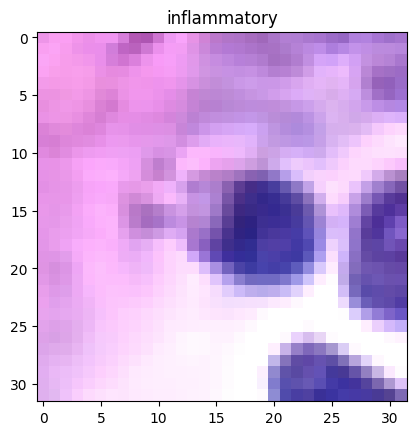

In [ ]:
img, label = train_custom_data[random.randint(0, len(train_custom_data) - 1)]
plt.imshow(img.permute(1, 2, 0))
print(label)
plt.title(train_custom_data.classes[label])

## Dataloader - How It Helps the Model
- Improves Generalization: Randomizing data prevents the model from learning the order of samples.

- Efficient Training: Batching allows the model to update weights after seeing multiple examples, leading to more stable and efficient learning.

- Faster Training: Parallel loading speeds up data delivery to the model, reducing idle time between batches.

- Memory Management: Loads only a few samples at a time, allowing training on large datasets without needing much memory.


In [ ]:
torch.manual_seed(1)
train_dataloader = torch.utils.data.DataLoader(dataset = train_custom_data, batch_size= 32, shuffle= True)
validation_dataloader = torch.utils.data.DataLoader(dataset= validation_custom_data, batch_size= 32, shuffle= False)

## train_dataloader:

- Loads data from the train_custom_data dataset.

- Uses a batch size of 32.

- Shuffling is enabled to help the model generalize better by preventing it from learning the order of the data.

## validation_dataloader:

- Loads data from the validation_custom_data dataset.

- Also uses a batch size of 32.

- Shuffling is disabled to ensure consistency

In [ ]:
imgs, labels = next(iter(train_dataloader))

print(labels)

tensor([3, 0, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 3, 2, 2, 1, 0, 1, 3, 1, 0, 1, 2,
        1, 2, 1, 1, 2, 0, 1, 2])


## Automation of Model training process:
- train_step() function helps in modifying the parameters in the model
- test_step() performs a simple forward pass for measuring the validation loss of the model
- loop_through() is an assitive function for combining the train_step() and test_step() as well as settings for how many epoch is required to be performed

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.CrossEntropyLoss,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

    model.to(device)
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.CrossEntropyLoss,
              device: torch.device):

    model.to(device)
    model.eval()
    test_loss, test_acc = 0.0, 0.0

    with torch.inference_mode():
        for X_test, y_test in dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_test_pred = model(X_test)
            test_loss += loss_fn(y_test_pred, y_test).item()

            y_pred_class = torch.argmax(torch.softmax(y_test_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y_test).sum().item() / len(y_test)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [ ]:
from tqdm.notebook import tqdm
import torch

def loop_through(model: torch.nn.Module,
                 train_dataloader: torch.utils.data.DataLoader,
                 test_dataloader: torch.utils.data.DataLoader,
                 loss_fn: torch.nn.CrossEntropyLoss,
                 optimizer: torch.optim.Optimizer,
                 epochs: int,
                 scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau = None,
                 results: dict = None,
                 device: torch.device = torch.device("cpu")):

    model.to(device)

    if results is None:
        results = {
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []
        }

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        if scheduler:
            scheduler.step(test_loss)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train_loss = {train_loss:.4f}, Train_acc = {train_acc:.4f}, "
              f"Test_loss = {test_loss:.4f}, Test_acc = {test_acc:.4f}")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results


In [ ]:
from typing import Dict, List
def plot_loss_acc(results : Dict[str , List[float]]):

  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  accuracy_test = results['test_acc']


  epochs = list(range(len(results['train_acc'])))
  print(f"{len(epochs)}")

  plt.figure(figsize = (16,8))

  #plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = 'train_accuracy')
  plt.plot(epochs, accuracy_test, label = 'test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.legend()

## Baseline Model Development
- For the baseline model, a Multilayer Perceptron (MLP) was chosen instead of a Convolutional Neural Network (CNN).

- Goal is to estabilish simple foundation and metrics for a fully connected network.

- They require less computational power and training time compared to CNNs.

- Although MLPs are not good at capturing data in images as effectively as CNNs, they provide a useful reference point to evaluate improvements.



In [ ]:
class Baseline_MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.architercture = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 32 * 32 * 3, out_features= 36),
            nn.ReLU(),
            nn.Linear(in_features= 36, out_features= 36),
            nn.ReLU(),
            nn.Linear(in_features= 36, out_features= 64),
            nn.ReLU(),
            nn.Linear(in_features= 64, out_features= 4)
        )

    def forward(self, x):
        return self.architercture(x)

In [ ]:
model0 = Baseline_MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr= 0.001)

In [ ]:
%pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(model0, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
Baseline_MLP                             [1, 4]                    --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Linear: 2-2                       [1, 36]                   110,628
│    └─ReLU: 2-3                         [1, 36]                   --
│    └─Linear: 2-4                       [1, 36]                   1,332
│    └─ReLU: 2-5                         [1, 36]                   --
│    └─Linear: 2-6                       [1, 64]                   2,368
│    └─ReLU: 2-7                         [1, 64]                   --
│    └─Linear: 2-8                       [1, 4]                    260
Total params: 114,588
Trainable params: 114,588
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.46
Estimated Total Si

### The MLP seems to be a simple model wiht only 114,588 trainable parameters

#Writing device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer= optimizer,
    mode= 'min',
    factor= 0.1,
    patience= 5,
)

results = {
    'train_loss' : [],
    'test_loss' : [],
    'train_acc' : [],
    'test_acc' : []
}

In [ ]:
model0_results = loop_through(model= model0, train_dataloader= train_dataloader, test_dataloader= validation_dataloader, loss_fn= loss_fn, optimizer= optimizer, epochs= 15, scheduler= scheduler, results= results, device= device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15: Train_loss = 1.3824, Train_acc = 0.2750, Test_loss = 1.3437, Test_acc = 0.5322
Epoch 2/15: Train_loss = 1.3805, Train_acc = 0.2747, Test_loss = 1.3384, Test_acc = 0.5322
Epoch 3/15: Train_loss = 1.3786, Train_acc = 0.2754, Test_loss = 1.3361, Test_acc = 0.5322
Epoch 4/15: Train_loss = 1.3759, Train_acc = 0.2761, Test_loss = 1.3322, Test_acc = 0.5322
Epoch 5/15: Train_loss = 1.3731, Train_acc = 0.2965, Test_loss = 1.3250, Test_acc = 0.5322
Epoch 6/15: Train_loss = 1.3692, Train_acc = 0.3354, Test_loss = 1.3207, Test_acc = 0.5322
Epoch 7/15: Train_loss = 1.3642, Train_acc = 0.3580, Test_loss = 1.3202, Test_acc = 0.5322
Epoch 8/15: Train_loss = 1.3566, Train_acc = 0.3853, Test_loss = 1.3034, Test_acc = 0.5391
Epoch 9/15: Train_loss = 1.3475, Train_acc = 0.3866, Test_loss = 1.2915, Test_acc = 0.5469
Epoch 10/15: Train_loss = 1.3359, Train_acc = 0.3991, Test_loss = 1.2669, Test_acc = 0.5381
Epoch 11/15: Train_loss = 1.3208, Train_acc = 0.3991, Test_loss = 1.2459, Test_acc = 0.54

15


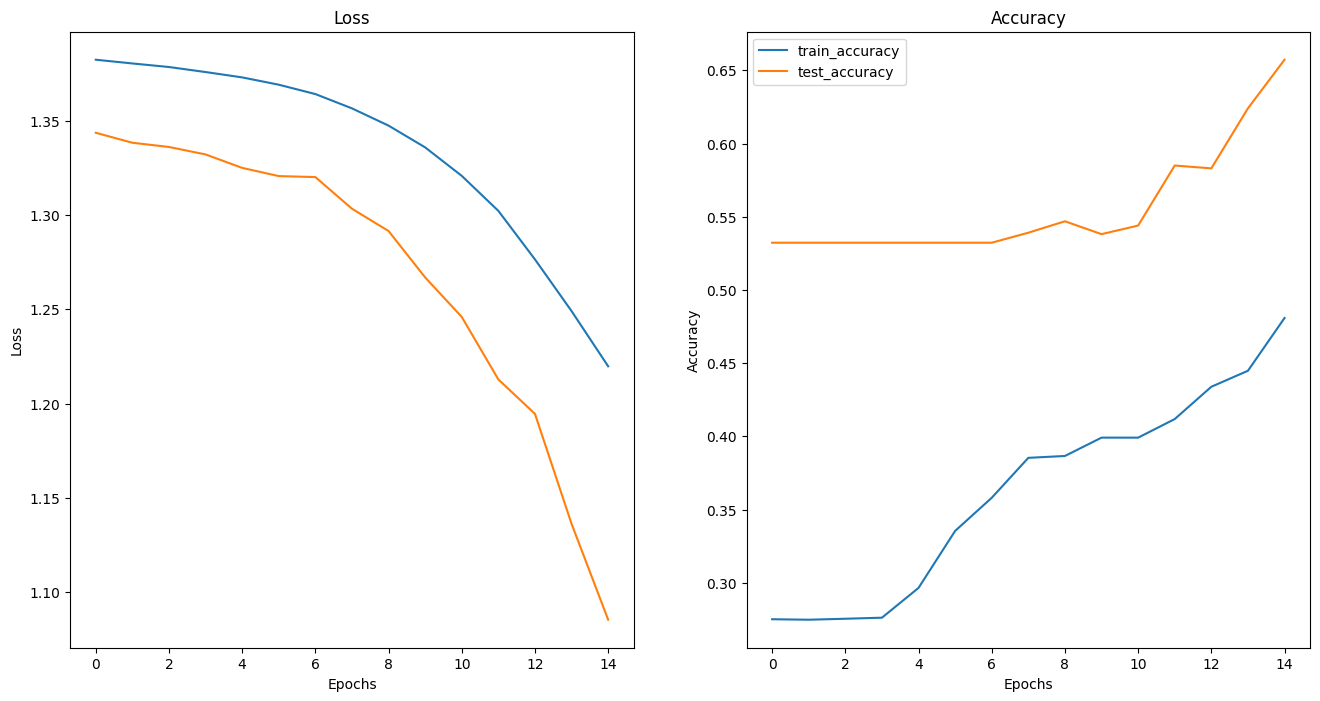

In [ ]:
plot_loss_acc(model0_results)

In [ ]:
all_preds = []
all_labels = []
model0.eval()
model0.to('cpu')
with torch.inference_mode():
    for item, label in test_custom_data:
        output = torch.argmax(torch.softmax(model0(item.unsqueeze(dim= 0)), dim= 1), dim= 1).item()
        all_preds.append(output)
        all_labels.append(label)




In [ ]:
print(all_preds[:50])
print(all_labels[:50])

[2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, zero_division= 0.0))



              precision    recall  f1-score   support

           0       0.39      0.05      0.08       148
           1       0.50      0.44      0.47       138
           2       0.56      0.98      0.71       392
           3       0.00      0.00      0.00       149

    accuracy                           0.55       827
   macro avg       0.36      0.37      0.32       827
weighted avg       0.42      0.55      0.43       827



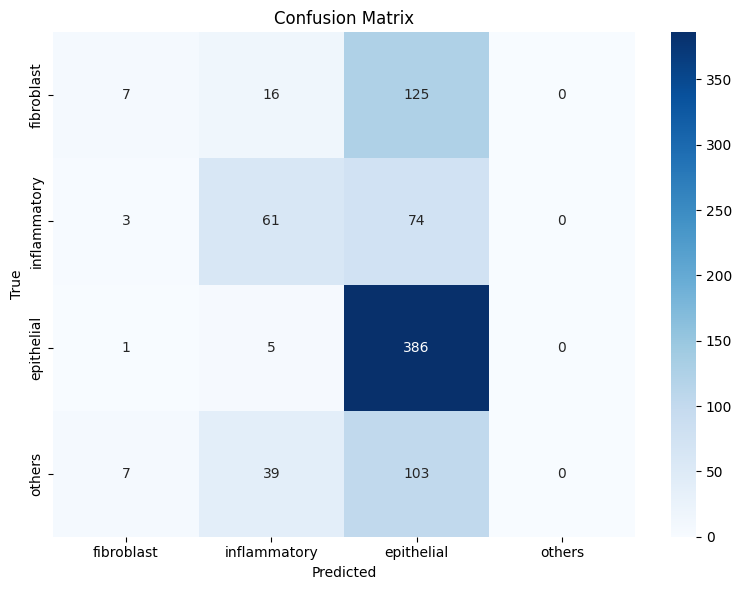

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_custom_data.classes, yticklabels= test_custom_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Observation
- The current model, a simple Multilayer Perceptron (MLP), is too shallow to  learn the complex patterns present in image data. MLPs treat input images as flat vectors, which means they ignore the spatial data that is very important.

- As a result, the model struggles to generalize and tends to predict only epithelial cells, showing signs of underfitting.

- To address this limitation, a more complex model such as a Convolutional Neural Network (CNN) is needed. CNNs are specifically designed for image data as they can capture local features like edges, textures, and shapes through convolutional filters, making them much more effective for visual pattern recognition.

In [ ]:
from torch import nn

class CNNMultiClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels= 32, stride= 1, padding= 1, kernel_size= 5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.25)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels= 32, out_channels= 32, stride= 1, padding = 0, kernel_size= 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.25)
        )

        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels= 32, out_channels= 64, stride= 1, padding= 1, kernel_size= 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.25)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels= 64, stride= 1, padding= 0, kernel_size= 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.25)
        )

        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 2304, out_features= 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features= 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features= 512, out_features= 4),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.max_pool1(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.max_pool2(x)
        x = self.fc_block(x)

        return x


#CNN Model Structure and Optimization Techniques
- The CNNMultiClassifier model is designed to  capture spatial features of image data by convolving throught the data, normalization, activation functions, and dropout layers, followed by fully connected layers for classification.

## Model Structure:
### Convolutional Blocks:

- The model consists 4 convolutional blocks (block1 - block4),  containing convolutional layers.

- The first two blocks use 32 filters, and the next two use 64 filters, allowinf the the model to learn more complex features.

- The use of 1x1 convolutions in block2 and block4 acts as bottleneck layers that reduce dimensionality and computational cost while maintaining information.

- Batch Normalization:

- Applied after each convolution, batch normalization helps stabilize and reduce training time by normalizing the output of the previous layer, reducing internal covariate shift.

###Activation Function (ReLU):

- The ReLU (Rectified Linear Unit) activation introduces non-linearity, enabling the model to be momre non-linear and learn comlex features.

###Dropout (Spatial and Standard):

- Dropout2d layers in the conv. blocks randomly deactivate entire feature neurons, which helps lessen the effects of overfitting by promoting redundancy and robustness in learned features.

###Max Pooling Layers:

- Two max pooling layers (max_pool1 and max_pool2) downsample the feature maps, reducing dimensions and computational load, making features more invariant to small translations.

###Fully Connected Block:

- After flattening the feature maps, two dense layers with 512 neurons each are used to learn complex combinations of the extracted features.

- The final linear layer outputs logits for 4 classes, corresponding to the classification task.

###Optimization Techniques:
- Batch Normalization enhances convergence speed and stability, allowing the use of higher learning rates.

- Dropout (both spatial in convolutional layers and standard in fully connected layers) mitigates overfitting, improving the model's generalization to unseen data.

- Use of Convolutions optimizes the model by reducing the parameters while preserving feature data.

- Max Pooling reduces the computational complexity and helps the model focus on the most important features.

###Together, these design choices ensure that the model balances complexity and regularization, enabling effective learning on image data while minimizing overfitting risks.

In [ ]:
model_Custom = CNNMultiClassifier()
summary(model_Custom, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
CNNMultiClassifier                       [1, 4]                    --
├─Sequential: 1-1                        [1, 32, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 32, 30, 30]           2,432
│    └─BatchNorm2d: 2-2                  [1, 32, 30, 30]           64
│    └─ReLU: 2-3                         [1, 32, 30, 30]           --
│    └─Dropout2d: 2-4                    [1, 32, 30, 30]           --
├─Sequential: 1-2                        [1, 32, 30, 30]           --
│    └─Conv2d: 2-5                       [1, 32, 30, 30]           1,056
│    └─BatchNorm2d: 2-6                  [1, 32, 30, 30]           64
│    └─ReLU: 2-7                         [1, 32, 30, 30]           --
│    └─Dropout2d: 2-8                    [1, 32, 30, 30]           --
├─MaxPool2d: 1-3                         [1, 32, 15, 15]           --
├─Sequential: 1-4                        [1, 64, 13, 13]           --
│    └─Co

In [ ]:
import numpy as np

results_custom = {
    'train_loss' : [],
    'test_loss' : [],
    'train_acc' : [],
    'test_acc' : []
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_Custom.parameters(), betas=(0.9, 0.99), weight_decay= 1e-6, lr=9e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer= optimizer,
    mode= 'min',
    factor= np.sqrt(0.1),
    patience= 5,
)

## Training Configuration Explanation
###Loss Function (CrossEntropyLoss):

- This loss function is suitable for multi-class classification tasks.
It measures the difference between the predicted class probabilities and the true class labels.

###Optimizer (Adam):

- Adam is an adaptive learning rate optimization algorithm that combines the benefits of RMSProp and momentum.

- It adjusts learning rates for each parameter individually, improving convergence speed and stability.

- The betas=(0.9, 0.99) parameters control the exponential decay rates for the moment estimates, balancing between stability and responsiveness.

- A small weight decay (1e-6) is applied to regularize the model and prevent overfitting by penalizing large weights.

- The learning rate (6e-5) is set low for gradual and stable updates during training.

### Learning Rate Scheduler (ReduceLROnPlateau):

- This scheduler reduces the learning rate when a monitored metric stops improving, helping the model escape plateaus during training.

- factor=np.sqrt(0.1) reduces the learning rate by approximately 31.6% when triggered.

- patience=5 allows the model 5 epochs of no improvement before reducing the learning rate.

In [ ]:
results_custom = loop_through(model= model_Custom, train_dataloader= train_dataloader, test_dataloader= validation_dataloader, loss_fn= loss_fn, optimizer= optimizer, epochs= 20, scheduler= scheduler, results= results_custom, device= device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Train_loss = 1.2140, Train_acc = 0.4399, Test_loss = 0.8078, Test_acc = 0.7129
Epoch 2/20: Train_loss = 1.0239, Train_acc = 0.5621, Test_loss = 0.7956, Test_acc = 0.7172
Epoch 3/20: Train_loss = 0.9696, Train_acc = 0.5927, Test_loss = 0.7324, Test_acc = 0.7266
Epoch 4/20: Train_loss = 0.9531, Train_acc = 0.5939, Test_loss = 0.7266, Test_acc = 0.7383
Epoch 5/20: Train_loss = 0.9372, Train_acc = 0.5977, Test_loss = 0.7411, Test_acc = 0.7357
Epoch 6/20: Train_loss = 0.9122, Train_acc = 0.6120, Test_loss = 0.7285, Test_acc = 0.7441
Epoch 7/20: Train_loss = 0.9070, Train_acc = 0.6150, Test_loss = 0.7788, Test_acc = 0.7260
Epoch 8/20: Train_loss = 0.8961, Train_acc = 0.6192, Test_loss = 0.7016, Test_acc = 0.7412
Epoch 9/20: Train_loss = 0.8808, Train_acc = 0.6265, Test_loss = 0.7350, Test_acc = 0.7309
Epoch 10/20: Train_loss = 0.8743, Train_acc = 0.6264, Test_loss = 0.8156, Test_acc = 0.7023
Epoch 11/20: Train_loss = 0.8777, Train_acc = 0.6274, Test_loss = 0.7165, Test_acc = 0.75

20


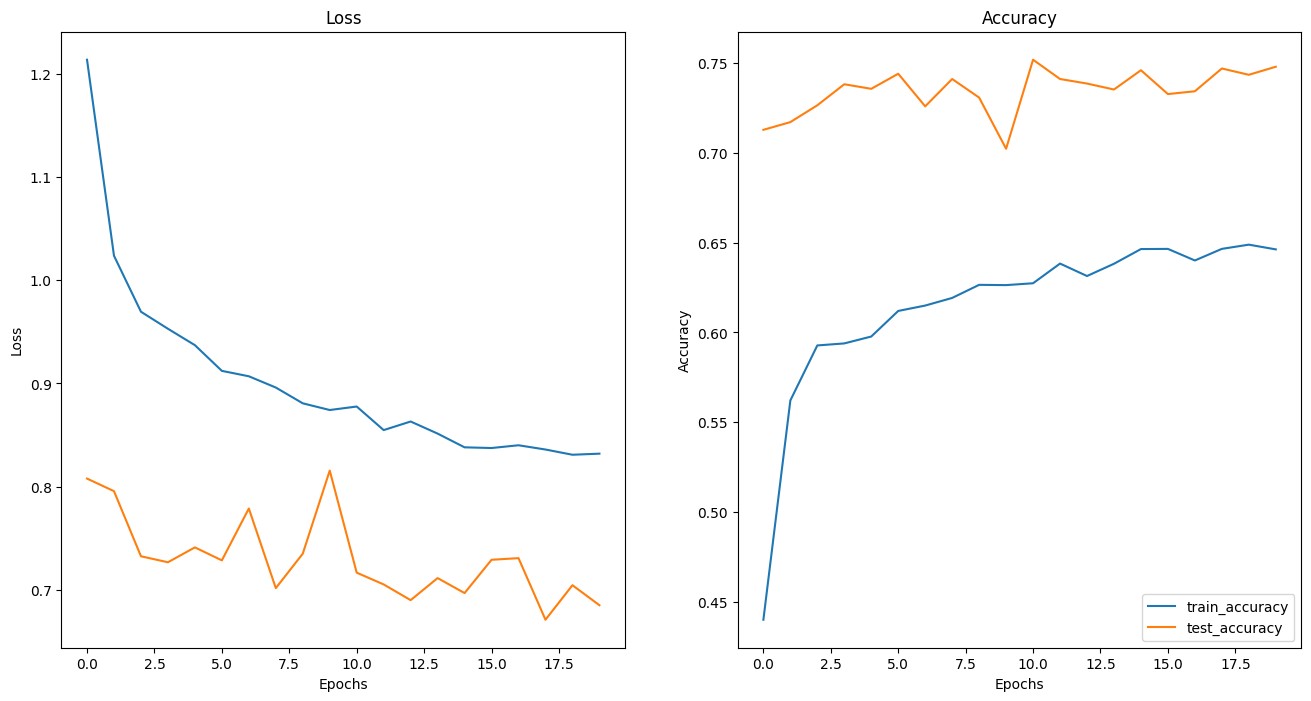

In [ ]:
plot_loss_acc(results_custom)

In [ ]:
all_preds = []
all_labels = []
model_Custom.to('cpu')
model_Custom.eval()

with torch.inference_mode():
    for item, label in validation_custom_data:
        output = torch.argmax(torch.softmax(model_Custom(item.unsqueeze(dim= 0)), dim= 1), dim= 1).item()
        all_preds.append(output)
        all_labels.append(label)




In [ ]:
print(all_preds[:50])
print(all_labels[:50])

[2, 3, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 0, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.36      0.28      0.32       113
           1       0.67      0.86      0.75       294
           2       0.86      0.86      0.86       533
           3       0.69      0.12      0.21        72

    accuracy                           0.75      1012
   macro avg       0.65      0.53      0.54      1012
weighted avg       0.74      0.75      0.72      1012



In [ ]:
test_df['cellTypeName'].value_counts()

,count
cellTypeName,
epithelial,392
others,149
fibroblast,148
inflammatory,138


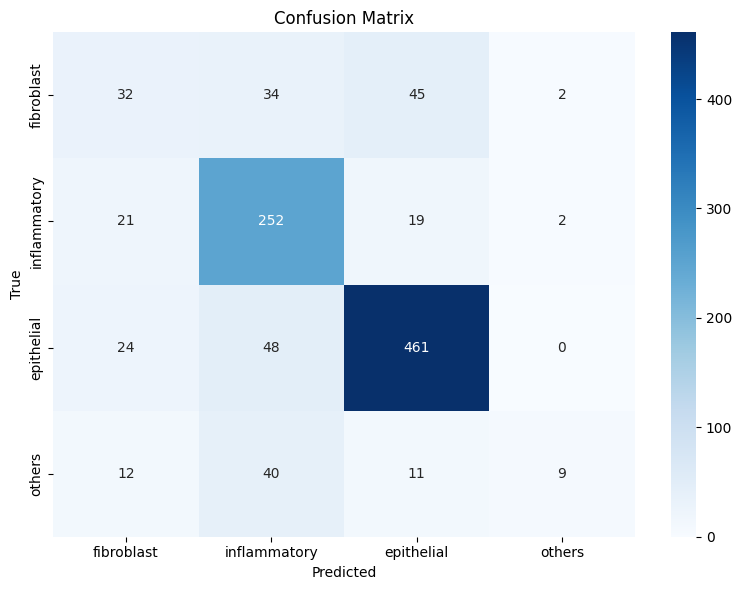

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_custom_data.classes, yticklabels= test_custom_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

#CNN Observation
- The  CNN model shows clear improvements in learning compared to the baseline MLP, indicating that it is able to extract relevant spatial features from the images.

- However, it struggles to accurately differentiate between "other" cell types and more dominant classes such as epithelial cells, suggesting that the current CNN model needs to have a more in-depth/layers and input retention for a more clearer understanding.

- Given these limitations, transitioning to a more advanced architecture like ResNet is a logical next step. ResNet's use of residual connections enables deeper networks to be trained more effectively, helping the model learn more complex features that may be essential for distinguishing between closely related cell types.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.in_channels = 64

        # Initial layer (Modified for 32x32 input)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # (B, 64, 32, 32)

        x = self.layer1(x)  # (B, 64, 32, 32)
        x = self.layer2(x)  # (B, 128, 16, 16)
        x = self.layer3(x)  # (B, 256, 8, 8)
        x = self.layer4(x)  # (B, 512, 4, 4)

        x = self.avgpool(x)  # (B, 512, 1, 1)
        x = torch.flatten(x, 1)  # (B, 512)
        x = self.fc(x)  # (B, num_classes)

        return x


In [ ]:
###########################################################################

#What is ResNet?
-ResNet (Residual Network), introduced in 2015, is a deep convolutional neural network architecture that fixes the issue of vanishing gradients in very deep networks. It does this using an important innovation called the residual connection or skip connection.

##Key Features:
-  Residual Blocks: Instead of learning from a direct mapping, ResNet learns the residual (F(x) = H(x) - x), and the original input (x) is added back at the end of the block:
Output = F(x) + x

- This makes sure that the model remembers the original input essence while preventing overfitting.

In [ ]:
resnet_implementation = ResNet18(num_classes= 4)

In [ ]:
summary(resnet_implementation, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─Sequential: 1-4                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 64, 32, 32]           --
│

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_implementation.parameters(), betas=(0.9, 0.99), weight_decay= 1e-6, lr=6e-5)
scheduler_resnet = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer= optimizer,
    mode= 'min',
    factor= np.sqrt(0.1),
    patience= 5,
)
resnet_results = {
    'train_loss' : [],
    'test_loss' : [],
    'train_acc' : [],
    'test_acc' : []
}

In [ ]:
resnet_results = loop_through(model= resnet_implementation, train_dataloader= train_dataloader, test_dataloader= validation_dataloader, loss_fn= loss_fn, optimizer= optimizer, epochs= 10, scheduler= scheduler_resnet, results= results_custom, device= device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: Train_loss = 0.8914, Train_acc = 0.6206, Test_loss = 0.8248, Test_acc = 0.7160
Epoch 2/10: Train_loss = 0.7679, Train_acc = 0.6760, Test_loss = 0.9057, Test_acc = 0.6246
Epoch 3/10: Train_loss = 0.7135, Train_acc = 0.7068, Test_loss = 0.6418, Test_acc = 0.7566
Epoch 4/10: Train_loss = 0.6703, Train_acc = 0.7292, Test_loss = 0.8608, Test_acc = 0.7008
Epoch 5/10: Train_loss = 0.6403, Train_acc = 0.7476, Test_loss = 0.7090, Test_acc = 0.7566
Epoch 6/10: Train_loss = 0.6124, Train_acc = 0.7588, Test_loss = 0.6387, Test_acc = 0.7586
Epoch 7/10: Train_loss = 0.5756, Train_acc = 0.7740, Test_loss = 0.5922, Test_acc = 0.7807
Epoch 8/10: Train_loss = 0.5584, Train_acc = 0.7800, Test_loss = 0.6165, Test_acc = 0.7734
Epoch 9/10: Train_loss = 0.5447, Train_acc = 0.7913, Test_loss = 0.6649, Test_acc = 0.7557
Epoch 10/10: Train_loss = 0.5149, Train_acc = 0.7988, Test_loss = 0.6224, Test_acc = 0.7639


30


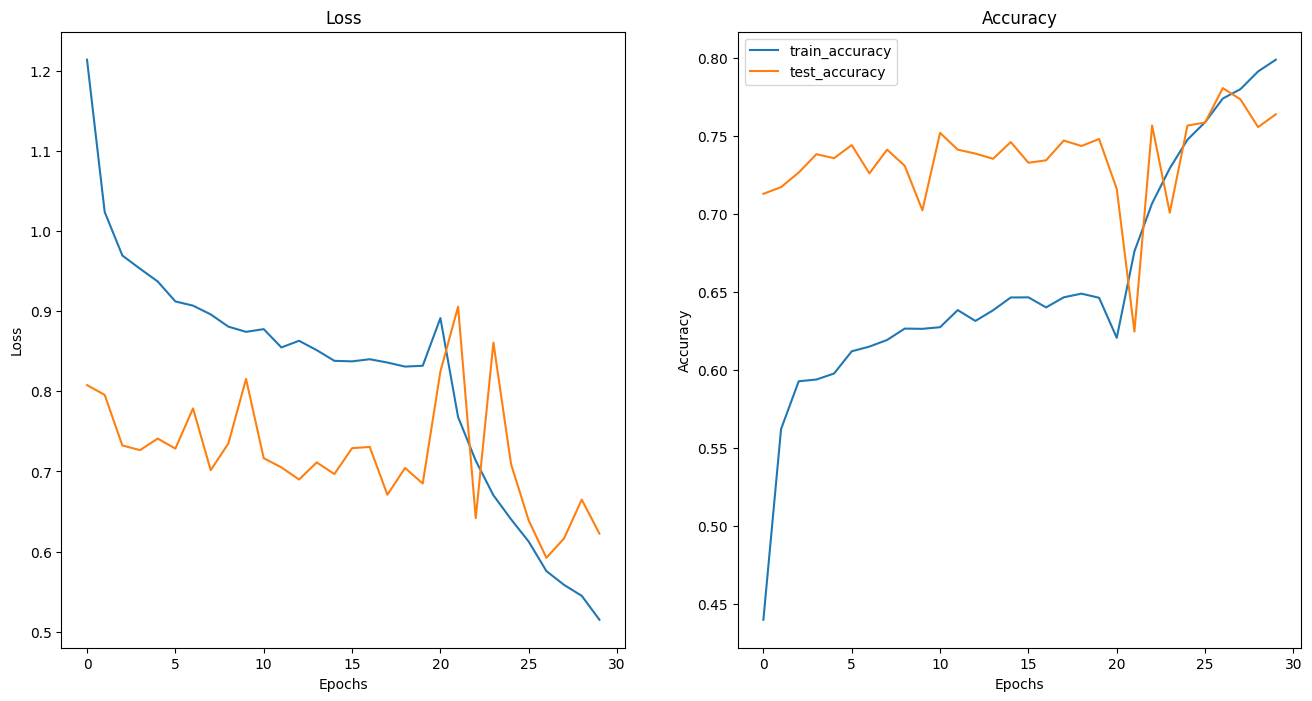

In [ ]:
plot_loss_acc(resnet_results)

In [ ]:
all_preds = []
all_labels = []
resnet_implementation.to('cpu')
resnet_implementation.eval()

with torch.inference_mode():
    for item, label in validation_custom_data:
        output = torch.argmax(torch.softmax(resnet_implementation(item.unsqueeze(dim= 0)), dim= 1), dim= 1).item()
        all_preds.append(output)
        all_labels.append(label)




In [ ]:
print(all_preds[:50])
print(all_labels[:50])

[0, 0, 1, 1, 0, 0, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       113
           1       0.65      0.88      0.75       294
           2       0.91      0.82      0.86       533
           3       0.57      0.46      0.51        72

    accuracy                           0.76      1012
   macro avg       0.68      0.64      0.65      1012
weighted avg       0.77      0.76      0.76      1012



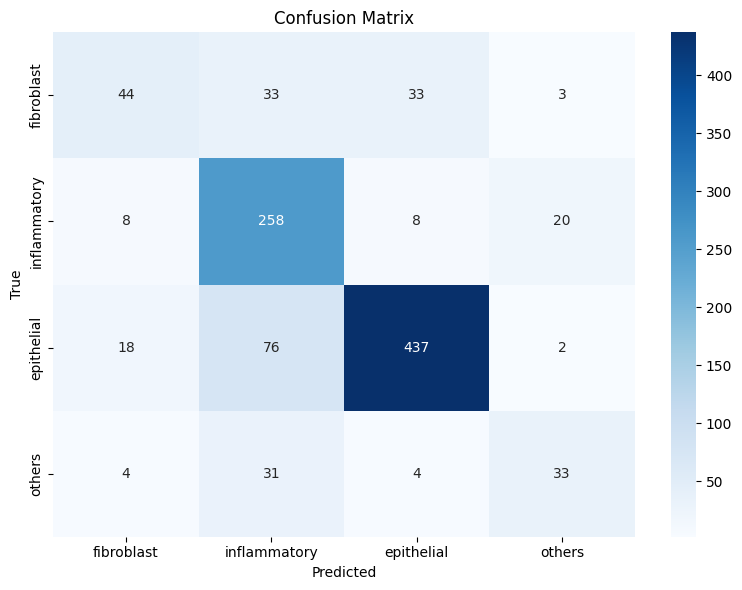

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_custom_data.classes, yticklabels= test_custom_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

##Observation
- The ResNet architecture shows a noticeable improvement in performance compared to the previous CNN model. From the results, it is observed that the model is now able to differentiate the "other" cell type which was either completely misclassified or ignored before

This indicates that expressive structure of ResNet, supported by residual connections, allows the model to better capture complex patterns in the data.

#Saving The Model Stats for Later Use

In [ ]:
torch.save(model0.state_dict(), 'mlp_base_pth')
torch.save(model_Custom.state_dict(), 'model_custom_pth')
torch.save(resnet_implementation.state_dict(), 'resnet_implementation_pth')

#Metric evaluation
##What metrics are used
- `Accuracy` -	Gives an overall idea of how many predictions were correct across all classes.
- `Weighted Precision` -	Balances the contribution of each class according to its support (number of samples). Useful for imbalanced data.
- `Weighted Recall` -	Indicates how well each class is being detected on average, adjusted for class frequency.
- `Weighted F1-score` -	Harmonic mean of weighted precision and recall – a single score capturing both false positives and false negatives, adjusted for class imbalance.
- `Class 3("others") F1-score` -Class-specific F1-score to observe model behavior on minor or **difficult classes** (like class 3 in your case). Helps pinpoint weaknesses.

<br>
<br>
<br>

##JUSTIFICATION


<table border="1" cellspacing="0" cellpadding="12" style="border-collapse: collapse; text-align: center; font-family: Arial, sans-serif; font-size: 16px; min-width: 800px;">
  <thead style="background-color: #e6f2ff;">
    <tr style="height: 50px;">
      <th>Model</th>
      <th>Accuracy</th>
      <th>Weighted Precision</th>
      <th>Weighted Recall</th>
      <th>Weighted F1</th>
      <th>Class 3 F1</th>
    </tr>
  </thead>
  <tbody>
    <tr style="height: 45px;">
      <td><strong>MLP</strong></td>
      <td>55%</td>
      <td>0.42</td>
      <td>0.55</td>
      <td>0.43</td>
      <td>0.00</td>
    </tr>
    <tr style="height: 45px;">
      <td><strong>CNN</strong></td>
      <td>75%</td>
      <td>0.74</td>
      <td>0.75</td>
      <td>0.72</td>
      <td>0.21</td>
    </tr>
    <tr style="height: 45px; background-color: #f9f9f9;">
      <td><strong>ResNet-18</strong></td>
      <td><strong>76%</strong></td>
      <td><strong>0.77</strong></td>
      <td><strong>0.76</strong></td>
      <td><strong>0.76</strong></td>
      <td><strong>0.51</strong></td>
    </tr>
  </tbody>
</table>

<br>
<br>
<br>

##MLP
- Accuracy: 55% - barely above random guessing.

- Performs very poorly on "other" class (F1 = 0.00), suggesting no meaningful learning for that class.

- Weak in handling spatial patterns in image data.

##CNN
- Accuracy: 75% - significant improvement.

- Much better weighted scores, especially in precision and recall.

- Can generalize better, especially for the dominant class (class 2).

- Still struggles with class "others" (F1 = 0.21), indicating limited learning depth or feature expressiveness.

##ResNet-18
- Best overall performer: Accuracy = 76%, weighted F1 = 0.76.

- Shows clear improvement in "others" class F1-score (0.51) - a sign it is able to better distinguish subtle class-specific features.

- Residual blocks allow deeper learning without vanishing gradients, which is critical for learning complex boundaries in medical images like cell types.

- More robust generalization across both frequent and rare classes.

<br>
<br>
<br>

A progressive evaluation strategy is used moving from basic to more advanced architectures. Each metric was chosen to highlight both overall performance and fairness across classes. This is important in domains like biomedical image classification, where failing to detect rare classes (like a certain cell type) can have high costs.

##Thus, ResNet-18 is the best model:

- Achieved the highest accuracy and weighted metrics.

- It demonstrates the best performance on difficult classes especially "others".

- And the chosen metrics confirm robust, fair, and interpretable evaluation.


In [ ]:
####################################

# Semi-Supervised Learning

## What is semi-supervised learning?
Semi-supervised learning is a type of machine learning technique that uses both labeled and unlabeled data for training. Normally, labeled data (with ground-truth labels) is limited or expensive to get, but unlabeled data is abundant. Semi-supervised learning aims to use the large amount of unlabeled data to improve model performance, especially when labeled data is less.


In [ ]:
extra_path = Path('Image_classification_data/data_labels_extraData.csv')

In [ ]:
extra_df = pd.read_csv(extra_path)

In [ ]:
extra_df

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


In [ ]:
new_df = pd.DataFrame(columns= data_df.columns)

In [ ]:

extra_df['image_path'] = extra_df['ImageName'].apply(lambda x : all_images_path / x)
extra_df.head()

,InstanceID,patientID,ImageName,isCancerous,image_path
0,12681,61,12681.png,0,Image_classification_data/patch_images/12681.png
1,12682,61,12682.png,0,Image_classification_data/patch_images/12682.png
2,12683,61,12683.png,0,Image_classification_data/patch_images/12683.png
3,12684,61,12684.png,0,Image_classification_data/patch_images/12684.png
4,12685,61,12685.png,0,Image_classification_data/patch_images/12685.png


In [ ]:
image_paths = extra_df['image_path'].tolist()
label_list = []
path_list = []
threshold = 0.8

resnet_implementation.eval()

for image_path in image_paths:
    img = Image.open(image_path)
    image_data = testing_transformation(img)
    image_data = image_data.unsqueeze(0)

    with torch.inference_mode():
        outputs = resnet_implementation(image_data)
        prediction_probs = torch.softmax(outputs, dim=1)
        max_prob, predicted_label = torch.max(prediction_probs, dim=1)

        if max_prob.item() >= threshold:
            label_list.append(predicted_label.item())
            path_list.append(image_path)


In [ ]:
print(label_list[:10])
print(path_list[:10])

[0, 0, 3, 0, 0, 0, 1, 0, 0, 0]
[PosixPath('Image_classification_data/patch_images/12684.png'), PosixPath('Image_classification_data/patch_images/12686.png'), PosixPath('Image_classification_data/patch_images/12688.png'), PosixPath('Image_classification_data/patch_images/12701.png'), PosixPath('Image_classification_data/patch_images/12706.png'), PosixPath('Image_classification_data/patch_images/12708.png'), PosixPath('Image_classification_data/patch_images/12710.png'), PosixPath('Image_classification_data/patch_images/12711.png'), PosixPath('Image_classification_data/patch_images/12713.png'), PosixPath('Image_classification_data/patch_images/12716.png')]


In [ ]:
import pandas as pd

classes = ['fibroblast', 'inflammatory', 'epithelial', 'others']

semi_supervised_df = pd.DataFrame(columns=['CellType', 'CellTypeName', 'image_path'])

for label, path in zip(label_list, path_list):
    cell_type_name = classes[label]
    semi_supervised_df.loc[len(semi_supervised_df)] = [label, cell_type_name, path]


In [ ]:
len(semi_supervised_df)

6412

#Pseudo-Supervised Learning:
- Initiated with a trained ResNet model that was previously trained on labeled images. Then took a set of unlabeled images and used this model to predict their labels.

- However, instead of trusting every prediction blindly, a confidence threshold  kept those predictions where the model was highly confident (above/equal to 80%). This step ensured that only reliable predictions were included.

- Once the collection of confidently predicted images and their labels was completed, these predictions were treated as ground truth labels. These labels were then stored in a dataframe that could be used for further training of the model.


#Refrences

S H Shabbeer Basha, Soumen Ghosh, Kancharagunta Kishan Babu, Shiv Ram Dubey, iswanath Pulabaigari, & nehasis Mukherjee. (2019, June 8). RCCNet. RCCNet: An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification. https://www.alphaxiv.org/abs/1810.02797

<br>
<br>

Nath, S. (2022, September 19). Implementing ResNet18 in PyTorch from Scratch. Machine Learning and Deep Learning. https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

<br>
<br>

AlexSoft. (2024, March 29). Semi-Supervised Learning, Explained with Examples. AltexSoft. Retrieved May 18, 2025, from https://www.altexsoft.com/blog/semi-supervised-learning/

##Google colab link (Pratyaksh Basel)
https://colab.research.google.com/drive/1E7cHHYEpxczJu4vkVNFnO_hjHkU7CgCk#scrollTo=oyjLQay9p1sw&uniqifier=1


In [ ]:
print("hello world")

hello world
